In [64]:
import numpy as np
from PIL import Image
import lmdb
#from matplotlib import pyplot as plt
from prettyplotlib import plt
import brewer2mpl
import cv2
import itertools
import os
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [85]:
green_purple = brewer2mpl.get_map('Paired', 'Qualitative', 11).mpl_colormap

dataset_labels = dict([('background', 0),
                    ('books', 1),
                    ('cabinets', 2),
                    ('ceiling', 3),
                    ('chair', 4),
                    ('computer', 5),
                    ('cup', 6),
                    ('bottle', 6),
                    ('door', 7),
                    ('fire_extinguisher', 8),
                    ('floor', 9),
                    ('fridge', 10),
                    ('keyboard', 11),
                    ('monitor', 12),
                    ('person', 13),
                    ('poster', 14),
                    ('signs', 15),
                    ('table', 16),
                    ('trashcan', 17),
                    ('walls', 18),
                    ('whiteboard', 19)])

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    label_ids = dataset_labels.keys()
    tick_marks = np.arange(len(label_ids))
    plt.xticks(tick_marks, label_ids, rotation=45)
    plt.yticks(tick_marks, label_ids)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_conf(labels,pred):
    labels = np.array(labels)
    labels = labels.flatten()
    print np.unique(labels)
    pred = np.array(pred)
    pred = pred.flatten()
    print np.unique(pred)
    conf = confusion_matrix(labels, pred)
    conf = conf[:,:]
    return conf

def custom_conf_plot(conf):
    print np.float(np.sum(np.diag(conf))) / np.sum(conf)
    conf_matrix = conf / conf.astype(np.float).sum(axis=1)
    #print(conf_matrix)
    print np.float(np.sum(np.diag(conf_matrix))) / conf.shape[0]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_matrix)
    fig.colorbar(cax)
    ax.set_xticklabels([''])
    ax.set_yticklabels([''])
    plt.show()
    plot_confusion_matrix(conf_matrix)

In [86]:
caffe_root = '/home/steve/caffe-custom/'
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

# init
caffe.set_mode_gpu()
caffe.set_device(0)

# load net
net = caffe.Net('office/deploy.prototxt', 'office/final.caffemodel', caffe.TEST)

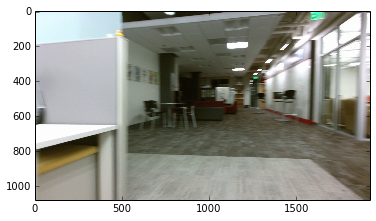

[ 0  2  3  4  7  9 14 16 18]


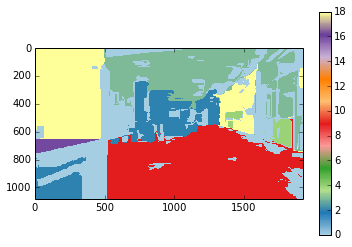

In [87]:
root_folder = "/data/Office4D/"
file1 = open(root_folder + 'testing.txt')
file3 = open(root_folder + 'testing_labels.txt')
numLine = 1050
for i, (line1,line3) in enumerate(itertools.izip(file1,file3)):
    if i == numLine:
        fields = line1.split(' ')
        #img = caffe.io.lo22ad_image(root_folder + fields[0])
        img = cv2.imread(fields[0])
        f2 = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
        
        fields = line3.split(' ')
        x = cv2.imread(fields[0],0)
        print np.unique(x)
        f3 = plt.imshow(x, cmap=green_purple, interpolation='nearest')
        plt.colorbar()
        plt.show()

    elif i == numLine + 1:
        break
file1.close()
file3.close()

(3, 227, 227)
(83,)
[ 0  3  9 18]
(1, 227, 227)
(227, 227)
82.0


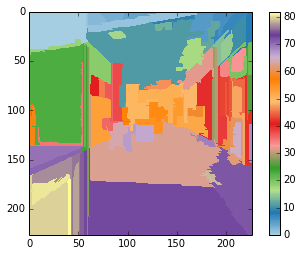

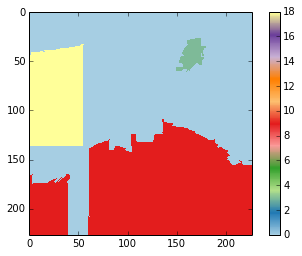

In [88]:
img = cv2.resize(img, (227,227))
in_ = np.array(img, dtype=np.float32)
in_ = in_[:,:,::-1]
in_ -= np.array((104.00698793,116.66876762,122.67891434))
in_ = in_.transpose((2,0,1))
print in_.shape
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()

out_probs = net.blobs['prob'].data[...]
out = out_probs[:,:].argmax(axis=1)
print out.shape
print np.unique(out)
seg = net.blobs['segmentations'].data[0]
print seg.shape
seg = seg.reshape(227,227)
print seg.shape
print np.max(seg)
f1 = plt.imshow(seg, cmap=green_purple, interpolation='nearest')
plt.colorbar()
plt.show()

#Replace segId with prob argmax
result = seg
for j in range(0,out.shape[0]):
    result[seg == j] = out[j]
#Just for visualization
f3 = plt.imshow(result, cmap=green_purple, interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
root_folder = "/data/Office4D/"
file1 = open(root_folder + 'testing.txt')
file3 = open(root_folder + 'testing_labels.txt')
labels = []
pred = []
end = 1000
for i, (line1,line3) in enumerate(itertools.izip(file1,file3)):
    fields = line1.split(' ')
    img = cv2.imread(fields[0])
    
    fields = line3.split(' ')
    x = cv2.imread(fields[0],0)
    x = cv2.resize(x, (227,227))
    labels.append(x.flatten())
    
    img = cv2.resize(img, (227,227))
    in_ = np.array(img, dtype=np.float32)
    in_ = in_[:,:,::-1]
    in_ -= np.array((104.00698793,116.66876762,122.67891434))
    in_ = in_.transpose((2,0,1))
    #shape for input (data blob is N x C x H x W), set data
    net.blobs['data'].reshape(1, *in_.shape)
    net.blobs['data'].data[...] = in_
    # run net and take argmax for prediction
    net.forward()
    
    out_probs = net.blobs['prob'].data[...]
    out = out_probs[:,:].argmax(axis=1)
    
    seg = net.blobs['segmentations'].data[0]
    seg = seg.reshape(227,227)

    #Replace segId with prob argmax
    result = seg
    for j in range(0,out.shape[0]):
        result[seg == j] = out[j]
    
    #Get comparison between ground truth and labels
    pred.append(result.flatten())
    
    if i == end:
        break

file1.close()
file3.close()

conf = get_conf(labels,pred)
print(conf)
custom_conf_plot(conf)
plot_confusion_matrix(conf)

0.453401670231
0.157703838


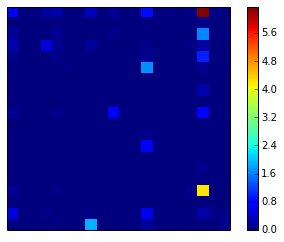

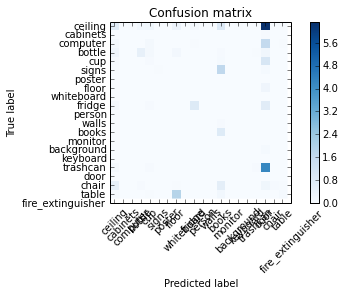

In [84]:
custom_conf_plot(conf)